In [ ]:
# 1) SETUP & IMPORTS
# (Run once per environment)
# !pip install -q pandas numpy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme()
pd.set_option("display.max_columns", None)

print("Imports ready.")


Imports ready.


In [ ]:
# 2) DATA PREPARATION

print("\n2. DATA PREPARATION")
print("-" * 40)


CSV_PATH = "apartments_for_rent_classified_10K.csv"

# Robust read: auto-detect delimiter (',' or ';')
df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")

# Normalize column names
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r"\s+", "_", regex=True))

# Drop 'price_display' if present (assignment requirement)
df.drop(columns=["price_display"], errors="ignore", inplace=True)

# Ensure we have a numeric target column named 'price'
def _extract_price(series: pd.Series, frame_len: int) -> pd.Series:
    if series is None:
        return pd.Series([np.nan]*frame_len)
    return (series.astype(str)
                 .str.replace(",", "", regex=False)
                 .str.extract(r"(\d{3,6})")[0]
                 .astype("float64"))

if "price" not in df.columns:
    candidate = None
    for col in ["title", "body"]:
        if col in df.columns:
            tmp = _extract_price(df[col], len(df))
            if tmp.notna().sum() > 0:
                candidate = tmp
                break
    if candidate is None:
        raise ValueError("No 'price' column and could not extract from 'title'/'body'.")
    df["price"] = candidate

# Keep valid numeric prices & trim extreme outliers for stability
df = df[pd.to_numeric(df["price"], errors="coerce").notna()].copy()
df["price"] = df["price"].astype(float)
df = df[(df["price"] >= 100) & (df["price"] <= 20000)].copy()

print("Shape after target cleaning:", df.shape)
display(df.head())

# Quick missingness overview
print("\nMissing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))



2. DATA PREPARATION
----------------------------------------
Shape after target cleaning: (9998, 21)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790.0,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425.0,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390.0,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,925.0,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,880.0,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401



Missing values (top 10):
pets_allowed    4161
amenities       3548
address         3327
state             77
cityname          77
bathrooms         34
latitude          10
longitude         10
bedrooms           7
body               0
dtype: int64



3. QUICK EDA
----------------------------------------


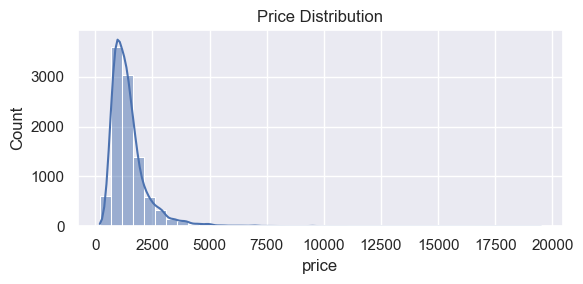

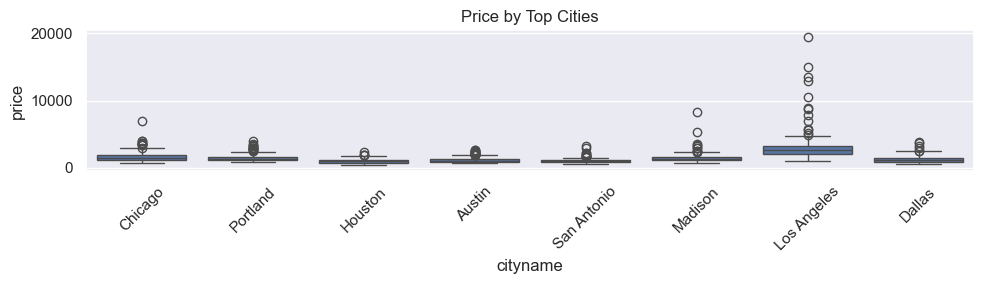

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9998 non-null   int64  
 1   category      9998 non-null   object 
 2   title         9998 non-null   object 
 3   body          9998 non-null   object 
 4   amenities     6450 non-null   object 
 5   bathrooms     9964 non-null   float64
 6   bedrooms      9991 non-null   float64
 7   currency      9998 non-null   object 
 8   fee           9998 non-null   object 
 9   has_photo     9998 non-null   object 
 10  pets_allowed  5837 non-null   object 
 11  price         9998 non-null   float64
 12  price_type    9998 non-null   object 
 13  square_feet   9998 non-null   int64  
 14  address       6671 non-null   object 
 15  cityname      9921 non-null   object 
 16  state         9921 non-null   object 
 17  latitude      9988 non-null   float64
 18  longitude     9988 non-null   flo

In [ ]:
# 3) QUICK EDA (DISCOVER & VISUALISE)

print("\n3. QUICK EDA")
print("-" * 40)

# Price distribution
plt.figure(figsize=(6,3))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Price Distribution")
plt.tight_layout()
plt.show()

# (Optional) Price by top cities if 'cityname' exists
if "cityname" in df.columns:
    top_cities = df["cityname"].value_counts().head(8).index
    plt.figure(figsize=(10,3))
    sns.boxplot(x="cityname", y="price", data=df[df["cityname"].isin(top_cities)])
    plt.xticks(rotation=45)
    plt.title("Price by Top Cities")
    plt.tight_layout()
    plt.show()

print(df.info())


In [ ]:
# 4) USER-DEFINED TRANSFORMER + DYNAMIC PREPROCESSOR

print("\n4. FEATURE ENGINEERING & PREPROCESSING")
print("-" * 40)

class AddCustomFeatures(BaseEstimator, TransformerMixin):
    """
    Adds engineered features; controlled by add_features (tuned later).
    - bed_bath_ratio
    - amenity_count
    - title_len / body_len
    - log_square_feet
    """
    def __init__(self, add_features=True):
        self.add_features = add_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not self.add_features:
            return X

        if {"bedrooms", "bathrooms"}.issubset(X.columns):
            X["bed_bath_ratio"] = X["bedrooms"] / (X["bathrooms"].replace(0, np.nan) + 1e-6)

        if "amenities" in X.columns:
            X["amenity_count"] = (
                X["amenities"].fillna("").astype(str).str.count(",")
                + (X["amenities"].notna()).astype(int)
            )

        if "title" in X.columns:
            X["title_len"] = X["title"].fillna("").astype(str).str.len()
        if "body" in X.columns:
            X["body_len"]  = X["body"].fillna("").astype(str).str.len()

        if "square_feet" in X.columns:
            X["log_square_feet"] = np.log1p(pd.to_numeric(X["square_feet"], errors="coerce"))

        return X


class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    Builds a ColumnTransformer AFTER features are added, so the column lists
    always match whether engineered features are on or off.
    """
    def __init__(self):
        self.preprocessor_ = None

    def fit(self, X, y=None):
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        cat_cols = [c for c in X.columns if c not in num_cols]

        num_tf = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])

        cat_tf = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ])

        self.preprocessor_ = ColumnTransformer([
            ("num", num_tf, num_cols),
            ("cat", cat_tf, cat_cols),
        ])
        self.preprocessor_.fit(X, y)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)

print("Transformers ready.")



4. FEATURE ENGINEERING & PREPROCESSING
----------------------------------------
Transformers ready.


In [ ]:
# 5) TRAIN / TEST SPLIT (80/20)

print("\n5. TRAIN / TEST SPLIT (80/20)")
print("-" * 40)

drop_cols = ["id", "source", "price_display"]  # safe drops; ignore if absent
use_cols = [c for c in df.columns if c not in drop_cols]

X = df[use_cols].copy()
y = df["price"].copy().astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)



5. TRAIN / TEST SPLIT (80/20)
----------------------------------------
Train shape: (7998, 19) Test shape: (2000, 19)


In [ ]:

# 6) RANDOM FOREST MODEL (BASELINE)
print("\n6. RANDOM FOREST — BASELINE TRAIN")
print("-" * 40)

rf_baseline = Pipeline([
    ("features", AddCustomFeatures(add_features=True)),  # baseline uses features
    ("prep",     DynamicPreprocessor()),
    ("model",    RandomForestRegressor(random_state=42, n_jobs=-1)),
])

rf_baseline.fit(X_train, y_train)
y_pred_base = rf_baseline.predict(X_test)

mse_base  = mean_squared_error(y_test, y_pred_base)
rmse_base = np.sqrt(mse_base)
mae_base  = mean_absolute_error(y_test, y_pred_base)
r2_base   = r2_score(y_test, y_pred_base)

print(f"Baseline RF — MAE: {mae_base:,.2f} | RMSE: {rmse_base:,.2f} | R²: {r2_base:.4f}")



6. RANDOM FOREST — BASELINE TRAIN
----------------------------------------
Baseline RF — MAE: 1.25 | RMSE: 14.72 | R²: 0.9997


In [8]:
# =========================
# 7) HYPERPARAMETER TUNING (Random Forest)
# =========================
print("\n7. HYPERPARAMETER TUNING (Random Forest)")
print("-" * 40)

rf_pipe = Pipeline([
    ("features", AddCustomFeatures()),     # toggled in search
    ("prep",     DynamicPreprocessor()),
    ("model",    RandomForestRegressor(random_state=42, n_jobs=-1)),
])

param_dist = {
    "features__add_features": [True, False],   # assignment requirement
    "model__n_estimators":    [150, 250, 350],
    "model__max_depth":       [None, 10, 20],
    "model__min_samples_leaf":[1, 2, 5],
    "model__min_samples_split":[2, 5, 10],
    "model__max_features":    ["sqrt", "log2", 0.5],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=15,                      # increase if you have time
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=1
)

rf_search.fit(X_train, y_train)
print("Best Params:", rf_search.best_params_)
print("CV Best RMSE:", -rf_search.best_score_)



7. HYPERPARAMETER TUNING (Random Forest)
----------------------------------------
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__n_estimators': 150, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 20, 'features__add_features': True}
CV Best RMSE: 151.90790473641073



8. FINAL EVALUATION (TEST SET)
----------------------------------------
MAE : 13.14
RMSE: 92.69
R²  : 0.9895


,MAE,RMSE,R2
RandomForest,13.14184,92.685974,0.989517


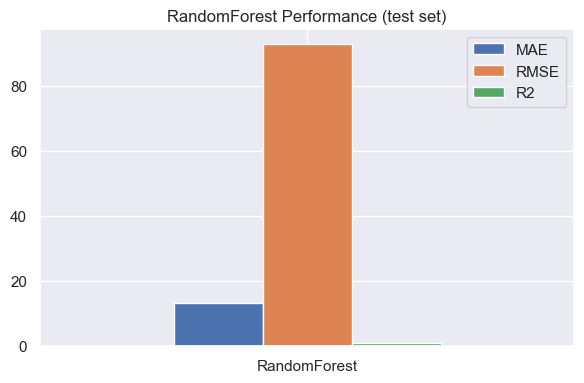

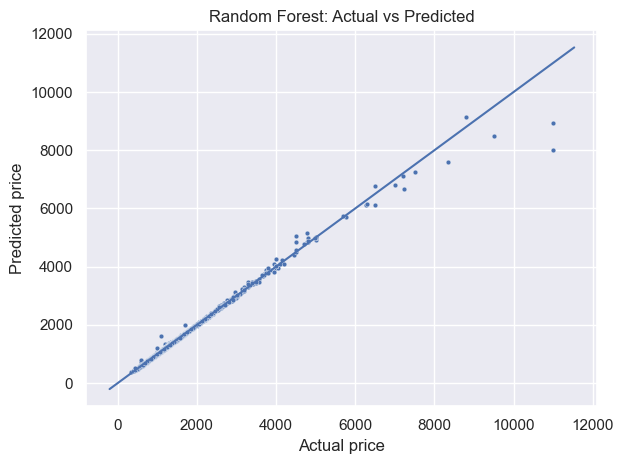

In [9]:
# =========================
# 8) FINAL EVALUATION (TEST SET)
# =========================
print("\n8. FINAL EVALUATION (TEST SET)")
print("-" * 40)

best_rf = rf_search.best_estimator_
y_pred  = best_rf.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)   # no squared=, so works on older sklearn
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:.4f}")

# Bar chart
results_df = pd.DataFrame({"RandomForest": {"MAE": mae, "RMSE": rmse, "R2": r2}}).T
display(results_df)

ax = results_df[["MAE","RMSE","R2"]].plot(kind="bar", figsize=(6,4))
plt.title("RandomForest Performance (test set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Diagnostic scatter
sns.scatterplot(x=y_test, y=y_pred, s=12)
plt.xlabel("Actual price"); plt.ylabel("Predicted price")
plt.title("Random Forest: Actual vs Predicted")
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims)
plt.tight_layout()
plt.show()



9. FEATURE IMPORTANCE (TOP 20)
----------------------------------------


,feature,importance
2,price,0.752956
24182,state_CA,0.071574
11,log_square_feet,0.040612
3,square_feet,0.035594
5,longitude,0.034273
0,bathrooms,0.024987
4,latitude,0.007359
23469,cityname_Los Angeles,0.005885
6,time,0.005304
1,bedrooms,0.003942


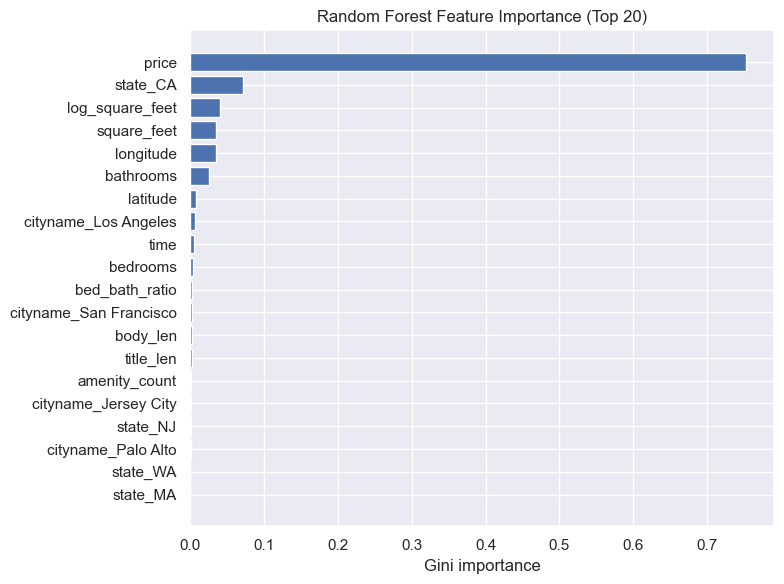

In [10]:
# =========================
# 9) FEATURE IMPORTANCE (TOP 20)
# =========================
print("\n9. FEATURE IMPORTANCE (TOP 20)")
print("-" * 40)

# Pull fitted steps
prep_wrapper  = best_rf.named_steps["prep"]          # DynamicPreprocessor
ct            = prep_wrapper.preprocessor_           # fitted ColumnTransformer
rf_model      = best_rf.named_steps["model"]

def get_feature_names_from_ct(ct: ColumnTransformer) -> np.ndarray:
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        # If transformer is a Pipeline, get the last step (OHE)
        enc = trans.named_steps[list(trans.named_steps.keys())[-1]] if hasattr(trans, "named_steps") else trans
        # New API
        try:
            names.extend(list(enc.get_feature_names_out(cols)))
            continue
        except Exception:
            pass
        # Old API
        try:
            names.extend(list(enc.get_feature_names(cols)))
            continue
        except Exception:
            pass
        # Fallback to raw column names
        if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
            names.extend(list(map(str, cols)))
        else:
            names.append(str(cols))
    return np.array(names, dtype=str)

try:
    feat_names = get_feature_names_from_ct(ct)
except Exception:
    feat_names = None

importances = rf_model.feature_importances_
if feat_names is None or len(feat_names) != len(importances):
    feat_names = np.array([f"f{i}" for i in range(len(importances))], dtype=str)

imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}) \
           .sort_values("importance", ascending=False)

top_n = 20
display(imp_df.head(top_n))

plt.figure(figsize=(8, max(4, top_n*0.3)))
subset = imp_df.head(top_n).iloc[::-1]
plt.barh(subset["feature"], subset["importance"])
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()


In [13]:
# Convert predictions into a Pandas Series with same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Sort predictions descending and take top 10
top_preds = y_pred_series.sort_values(ascending=False).head(10)

# Compare actual vs predicted
comparison = pd.DataFrame({
    "Actual": y_test.loc[top_preds.index],
    "Predicted": top_preds
})

print(comparison)


       Actual    Predicted
9892   8800.0  9126.934198
8573  11000.0  8940.935357
9649   9500.0  8494.416944
9946  11000.0  8020.185492
9988   8345.0  7593.339921
9128   7500.0  7265.503254
9770   7200.0  7116.984931
9872   7000.0  6795.127905
9965   6500.0  6761.141111
9734   7240.0  6655.903016


In [14]:
# Show bottom 10 predicted values (lowest predictions)
bottom_preds = pd.Series(y_pred, index=y_test.index).sort_values(ascending=True).head(10)

comparison_bottom = pd.DataFrame({
    "Actual": y_test.loc[bottom_preds.index],
    "Predicted": bottom_preds
})

print(comparison_bottom)


      Actual   Predicted
263    325.0  376.390770
346    386.0  421.486287
2344   400.0  422.386175
2701   425.0  432.907389
1807   425.0  439.011905
3095   415.0  444.790524
1981   450.0  460.998746
474    425.0  467.357722
1513   450.0  467.922794
23     450.0  482.863254


Baseline DT — MAE: 3.57 | RMSE: 65.91 | R²: 0.9947
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best DT params: {'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 15, 'features__add_features': True}
CV best RMSE: 93.27157562635868


,MAE,RMSE,R2
DecisionTree,7.445833,197.336079,0.952479


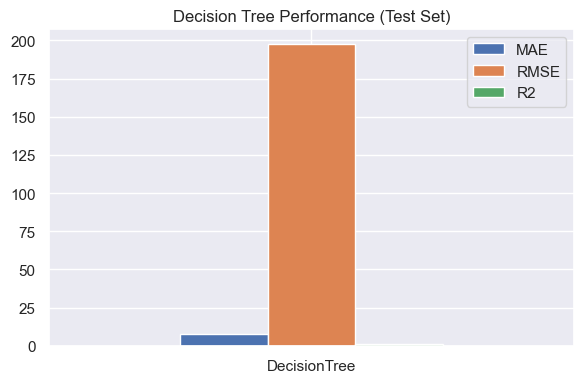


Top 10 predicted vs actual (Decision Tree)


,Actual,Predicted
8573,11000.0,17225.0
9946,11000.0,17225.0
9649,9500.0,9500.0
9892,8800.0,8950.0
9988,8345.0,8350.0
9770,7200.0,7550.0
9734,7240.0,7450.0
9128,7500.0,7450.0
9872,7000.0,7000.0
7129,6500.0,6600.0



Bottom 10 predicted vs actual (Decision Tree)


,Actual,Predicted
263,325.0,287.666667
346,386.0,392.500000
2344,400.0,400.000000
3095,415.0,422.000000
6649,425.0,425.000000
2701,425.0,425.000000
1807,425.0,425.000000
474,425.0,425.000000
1981,450.0,450.000000
23,450.0,450.000000


In [ ]:
# Decision Tree Regressor  
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dt_pipe = Pipeline([
    ("features", AddCustomFeatures()),
    ("prep",     DynamicPreprocessor()),
    ("model",    DecisionTreeRegressor(random_state=42)),
])

# Baseline
dt_pipe.set_params(features__add_features=True)
dt_pipe.fit(X_train, y_train)
y_pred_dt_base = dt_pipe.predict(X_test)
print("Baseline DT — MAE: {:.2f} | RMSE: {:.2f} | R²: {:.4f}".format(
    mean_absolute_error(y_test, y_pred_dt_base),
    np.sqrt(mean_squared_error(y_test, y_pred_dt_base)),
    r2_score(y_test, y_pred_dt_base)
))

# Tuning
param_dist_dt = {
    "features__add_features": [True, False],
    "model__max_depth":         [None, 6, 8, 10, 12, 15],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf":  [1, 2, 5, 10],
    "model__max_features":      [None, "sqrt", "log2", 0.5],
}

dt_search = RandomizedSearchCV(
    dt_pipe,
    param_distributions=param_dist_dt,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=1
)
dt_search.fit(X_train, y_train)
print("Best DT params:", dt_search.best_params_)
print("CV best RMSE:", -dt_search.best_score_)

# Final test evaluation
best_dt = dt_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)

mae_dt  = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt   = r2_score(y_test, y_pred_dt)

results_dt = pd.DataFrame({"DecisionTree": {"MAE": mae_dt, "RMSE": rmse_dt, "R2": r2_dt}}).T
display(results_dt)

# Plot
ax = results_dt[["MAE","RMSE","R2"]].plot(kind="bar", figsize=(6,4))
plt.title("Decision Tree Performance (Test Set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Top/Bottom 10 comparisons
pred_series_dt = pd.Series(y_pred_dt, index=y_test.index)
top_preds_dt = pred_series_dt.sort_values(ascending=False).head(10)
bottom_preds_dt = pred_series_dt.sort_values(ascending=True).head(10)

print("\nTop 10 predicted vs actual (Decision Tree)")
display(pd.DataFrame({"Actual": y_test.loc[top_preds_dt.index], "Predicted": top_preds_dt}))

print("\nBottom 10 predicted vs actual (Decision Tree)")
display(pd.DataFrame({"Actual": y_test.loc[bottom_preds_dt.index], "Predicted": bottom_preds_dt}))


Baseline LR — MAE: 0.36 | RMSE: 1.00 | R²: 1.0000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best LR params: {'features__add_features': False}
CV best RMSE: 0.9155822745908347


,MAE,RMSE,R2
LinearRegression,0.361509,0.960819,0.999999


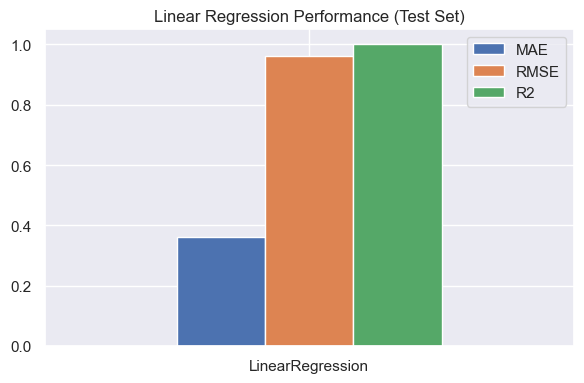


Top 10 predicted vs actual (Linear Regression)


,Actual,Predicted
8573,11000.0,10991.584455
9946,11000.0,10991.246605
9649,9500.0,9494.435858
9892,8800.0,8796.043502
9988,8345.0,8341.406047
9128,7500.0,7496.469736
9734,7240.0,7234.842017
9770,7200.0,7196.149910
9872,7000.0,6996.681246
9965,6500.0,6497.533434



Bottom 10 predicted vs actual (Linear Regression)


,Actual,Predicted
263,325.0,324.899768
346,386.0,386.226296
2344,400.0,400.235672
3095,415.0,415.276858
474,425.0,424.876083
2701,425.0,425.394730
1807,425.0,425.576856
6649,425.0,425.594142
1513,450.0,449.875871
23,450.0,450.127686


In [21]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd, matplotlib.pyplot as plt

lin_pipe = Pipeline([
    ("features", AddCustomFeatures()),
    ("prep",     DynamicPreprocessor()),
    ("model",    LinearRegression()),
])

# Baseline
lin_pipe.set_params(features__add_features=True)
lin_pipe.fit(X_train, y_train.astype(float))
y_pred_lin_base = lin_pipe.predict(X_test)
print("Baseline LR — MAE: {:.2f} | RMSE: {:.2f} | R²: {:.4f}".format(
    mean_absolute_error(y_test, y_pred_lin_base),
    np.sqrt(mean_squared_error(y_test, y_pred_lin_base)),
    r2_score(y_test, y_pred_lin_base)
))

# “Tuning” (toggle engineered features)
param_dist_lin = { "features__add_features": [True, False] }
lin_search = RandomizedSearchCV(
    lin_pipe,
    param_distributions=param_dist_lin,
    n_iter=2,
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=1
)
lin_search.fit(X_train, y_train.astype(float))
print("Best LR params:", lin_search.best_params_)
print("CV best RMSE:", -lin_search.best_score_)

# Final test evaluation
best_lin   = lin_search.best_estimator_
y_pred_lin = best_lin.predict(X_test)

mae_lin  = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin   = r2_score(y_test, y_pred_lin)

lin_results = pd.DataFrame({"LinearRegression": {"MAE": mae_lin, "RMSE": rmse_lin, "R2": r2_lin}}).T
display(lin_results)

# Plot
ax = lin_results[["MAE","RMSE","R2"]].plot(kind="bar", figsize=(6,4))
plt.title("Linear Regression Performance (Test Set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Extremes
pred_series_lin = pd.Series(y_pred_lin, index=y_test.index)
print("\nTop 10 predicted vs actual (Linear Regression)")
display(pd.DataFrame({"Actual": y_test.loc[pred_series_lin.nlargest(10).index],
                      "Predicted": pred_series_lin.nlargest(10)}))
print("\nBottom 10 predicted vs actual (Linear Regression)")
display(pd.DataFrame({"Actual": y_test.loc[pred_series_lin.nsmallest(10).index],
                      "Predicted": pred_series_lin.nsmallest(10)}))


Baseline GaussianNB — Acc: 0.381 | F1(macro): 0.330

Classification report (baseline):
              precision    recall  f1-score   support

           0       0.57      0.11      0.19       517
           1       0.34      0.39      0.36       529
           2       0.46      0.17      0.25       470
           3       0.37      0.87      0.52       484

    accuracy                           0.38      2000
   macro avg       0.44      0.38      0.33      2000
weighted avg       0.44      0.38      0.33      2000

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best NB params: {'features__add_features': True, 'model__var_smoothing': np.float64(1e-07)}
CV best accuracy: 0.4018504626156539

GaussianNB (tuned) — Acc: 0.389 | F1(macro): 0.342

Classification report (tuned):
              precision    recall  f1-score   support

           0       0.60      0.13      0.21       517
           1       0.35      0.40      0.37       529
           2       0.46      0.18      0.

,Accuracy,F1_macro,MAE(midpoint),RMSE(midpoint)
GaussianNB,0.389,0.342345,5013.3985,6629.76982


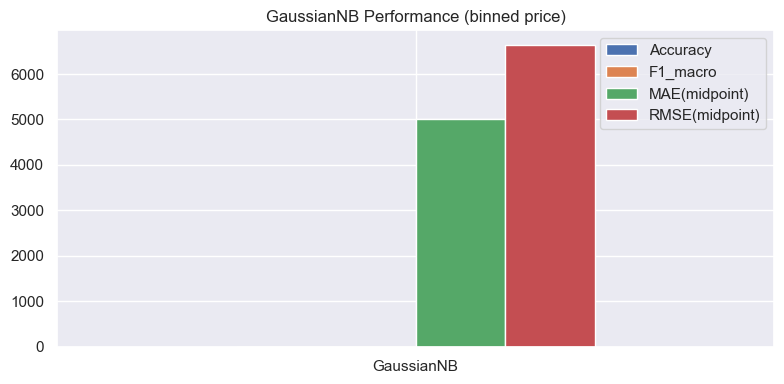


Top 10 predicted price (NB midpoint) vs actual


,Actual,Predicted(mid)
4122,2595.0,10597.5
1731,985.0,10597.5
6391,1635.0,10597.5
4376,1175.0,10597.5
576,1125.0,10597.5
6838,1200.0,10597.5
2750,1035.0,10597.5
4321,1634.0,10597.5
9238,2095.0,10597.5
3728,1084.0,10597.5



Bottom 10 predicted price (NB midpoint) vs actual


,Actual,Predicted(mid)
582,775.0,574.5
2678,1050.0,574.5
5545,625.0,574.5
1513,450.0,574.5
6037,760.0,574.5
6884,699.0,574.5
2498,1186.0,574.5
5304,1025.0,574.5
7793,825.0,574.5
3433,839.0,574.5


In [22]:
# Naive Bayes (GaussianNB) — classification on binned price
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- Build a dense preprocessor (GaussianNB needs dense arrays) ---
def make_dense_preprocessor(X_sample: pd.DataFrame):
    num_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_sample.columns if c not in num_cols]

    num_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    # handle both new and old sklearn APIs
    try:
        cat_tf = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
    except TypeError:
        cat_tf = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ])

    return ColumnTransformer([
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ], remainder="drop")

# --- Create global bin edges from the full target to keep consistency ---
# (quartiles by default; change q if you want 3 or 5 bins, etc.)
q = [0, 0.25, 0.5, 0.75, 1.0]
bin_edges = np.quantile(y.astype(float), q)
bin_edges[0] -= 1e-6  # ensure include_lowest works cleanly

# classification targets from train/test prices
y_train_cls = pd.cut(y_train.astype(float), bins=bin_edges, labels=False, include_lowest=True)
y_test_cls  = pd.cut(y_test.astype(float),  bins=bin_edges, labels=False, include_lowest=True)

# midpoints for converting class -> representative price (for MAE/RMSE later)
bin_mid = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# --- Pipeline (features -> dense preprocessor -> GaussianNB) ---
dense_ct = make_dense_preprocessor(X_train)
nb_pipe = Pipeline([
    ("features", AddCustomFeatures()),     # we’ll toggle add_features in tuning
    ("prep",     dense_ct),
    ("model",    GaussianNB()),
])

# Baseline
nb_pipe.set_params(features__add_features=True)
nb_pipe.fit(X_train, y_train_cls)
y_pred_cls_base = nb_pipe.predict(X_test)

acc_b = accuracy_score(y_test_cls, y_pred_cls_base)
f1_b  = f1_score(y_test_cls, y_pred_cls_base, average="macro")
print("Baseline GaussianNB — Acc: {:.3f} | F1(macro): {:.3f}".format(acc_b, f1_b))
print("\nClassification report (baseline):")
print(classification_report(y_test_cls, y_pred_cls_base))

# “Tuning” (var_smoothing and feature toggle)
param_grid_nb = {
    "features__add_features": [True, False],
    "model__var_smoothing":   np.logspace(-12, -7, 6),
}

nb_search = GridSearchCV(
    nb_pipe,
    param_grid=param_grid_nb,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",   # or "f1_macro"
    verbose=1
)
nb_search.fit(X_train, y_train_cls)
print("Best NB params:", nb_search.best_params_)
print("CV best accuracy:", nb_search.best_score_)

# Final test evaluation
best_nb    = nb_search.best_estimator_
y_pred_cls = best_nb.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)
f1  = f1_score(y_test_cls, y_pred_cls, average="macro")
print("\nGaussianNB (tuned) — Acc: {:.3f} | F1(macro): {:.3f}".format(acc, f1))
print("\nClassification report (tuned):")
print(classification_report(y_test_cls, y_pred_cls))

# ---- Optional: map predicted class -> price midpoint to get MAE/RMSE vs true price ----
pred_price = pd.Series(y_pred_cls, index=y_test.index).map(lambda c: bin_mid[int(c)])
mae_nb  = np.mean(np.abs(y_test.astype(float) - pred_price))
rmse_nb = np.sqrt(np.mean((y_test.astype(float) - pred_price) ** 2))

nb_results = pd.DataFrame({
    "GaussianNB": {
        "Accuracy": acc,
        "F1_macro": f1,
        "MAE(midpoint)": mae_nb,
        "RMSE(midpoint)": rmse_nb
    }
}).T

display(nb_results)

# Plot classification metrics
ax = nb_results[["Accuracy","F1_macro","MAE(midpoint)","RMSE(midpoint)"]].plot(kind="bar", figsize=(8,4))
plt.title("GaussianNB Performance (binned price)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Extremes by predicted class (optional)
pred_series_nb = pd.Series(pred_price, index=y_test.index)  # predicted price midpoint
print("\nTop 10 predicted price (NB midpoint) vs actual")
display(pd.DataFrame({"Actual": y_test.loc[pred_series_nb.nlargest(10).index],
                      "Predicted(mid)": pred_series_nb.nlargest(10)}))

print("\nBottom 10 predicted price (NB midpoint) vs actual")
display(pd.DataFrame({"Actual": y_test.loc[pred_series_nb.nsmallest(10).index],
                      "Predicted(mid)": pred_series_nb.nsmallest(10)}))
